### MID model simulation

Russ Poldrack, Jeanette Mumford, and Michael Demidenko

This is a modification of MID_sim_refactor.ipynb, which changes the model to computing a group analysis rather than computing the p-values per subject.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from poldracklab.fmri.spm_hrf import spm_hrf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from scipy.stats import ttest_1samp
import pickle

np.random.seed(42)
print('Detected %d cores.' % multiprocessing.cpu_count())

Detected 16 cores.


### Generate data loading function

In [2]:
# use data from both runs, concatenate them
def get_subdata(sub, verbose=False):
    sub = str(sub).zfill(2)
    events_df = None
    maxtime = None
    for run in [1,2]:
        eventfile = f'AHRB/sub-{sub}/ses-1/func/sub-{sub}_ses-1_task-mid_run-0{run}_events.tsv'
        df = pd.read_csv(eventfile, sep='\t')
        if verbose:
            print(f'Loading {eventfile}')
            print(df.shape)
        assert df.shape[1] > 2, f'bad parsing'
        if events_df is None:
            events_df = df
            maxtime = np.ceil(events_df['FEEDBACK_ONSET'].max() + events_df['FEEDBACK_DURATION'].values[-1])
        else:
            onset_cols = [col for col in df.columns if 'ONSET' in col]
            for col in onset_cols:
                df[col] += maxtime
            events_df = pd.concat([events_df, df])
    return events_df

events = get_subdata(1, True)
print(events.shape)
print(events.TRIAL_TYPE.value_counts())
events.head()



Loading AHRB/sub-01/ses-1/func/sub-01_ses-1_task-mid_run-01_events.tsv
(50, 13)
Loading AHRB/sub-01/ses-1/func/sub-01_ses-1_task-mid_run-02_events.tsv
(50, 13)
(100, 13)
NoMoneyStake    20
LargeLoss       20
LargeGain       20
SmallLoss       20
SmallGain       20
Name: TRIAL_TYPE, dtype: int64


,TRIAL_TYPE,CUE_ONSET,CUE_DURATION,FIXATION_ONSET,FIXATION_DURATION,PROBE_ONSET,PROBE_DURATION,FEEDBACK_ONSET,FEEDBACK_DURATION,TRIAL_RESULT,RESULT_REASON,PROBE_HIT,PROBE_MRT
0,NoMoneyStake,0.058,2,2.008,2.0,4.007,0.319,4.407,1.631,No money at stake!,You pressed too slow!,0,0
1,NoMoneyStake,6.024,2,8.007,1.5,9.506,0.319,9.906,1.631,No money at stake!,You pressed too slow!,0,0
2,LargeLoss,11.556,2,13.506,2.5,16.005,0.319,16.405,1.631,You keep $5!,Correct Response!,1,306
3,NoMoneyStake,18.022,2,20.005,1.5,21.504,0.319,21.904,1.631,No money at stake!,Correct Response!,1,318
4,LargeGain,23.554,2,25.504,1.5,27.004,0.319,27.403,1.631,You did not earn $5!,You pressed too slow!,0,0


### Generate functions to create full design matrix

Here we include separate regressors for each of the 5 conditions (NoMoneyStake, LargeLoss, SmallLoss, LargeGain, SmallGain) for each trial component (Cue, Fixation, Probe, and Feedback). We also separate feedback regressors by hit/miss trials.

In [3]:
## create full design matrix with convolved regressors
# separate all task components by condition
# also separate feedback by hit/miss

def make_stick_function(onsets, durations, length, resolution=.1):
    """
    Create a stick function with onsets and durations

    Parameters
    ----------
    onsets : list
        List of onset times
    durations : list
        List of duration times
    length : float
        Length of the stick function (in seconds)
    resolution : float
        Resolution of the stick function (in seconds)
        0.1 secs by default
    
    Returns
    -------
    sf : np.array
        Timepoints of the stick function
    """
    timepoints = np.arange(0, length, resolution)
    sf = np.zeros_like(timepoints)
    for onset, duration in zip(onsets, durations):
        sf[(timepoints >= onset) & (timepoints < onset + duration)] = 1
    sf_df = pd.DataFrame({'sf': sf})
    sf_df.index = timepoints
    return sf_df

def create_design_matrix(events_df, resolution=.1, hrf_length=32, verbose=False):
    # create the full design matrix
    maxtime = np.ceil(events_df['FEEDBACK_ONSET'].max() + events_df['FEEDBACK_DURATION'].values[-1])
    timepoints = np.arange(0, maxtime, resolution)
    if verbose:
        print(f'Maxtime: {maxtime}')
        print(f'Timepoints: {timepoints.shape}')
    event_classes = ['CUE', 'FIXATION', 'PROBE', 'FEEDBACK']
    trial_types = events_df.TRIAL_TYPE.unique().tolist()
    desmtx = pd.DataFrame()
    desmtx_conv = pd.DataFrame()
    for trial_type in trial_types:
        for event_class in event_classes:
            if verbose:
                print(f'Creating stick function for {event_class}')
            if event_class != 'FEEDBACK':
                events_trialtype = events_df[events_df.TRIAL_TYPE == trial_type]
                onsets = events_trialtype[f'{event_class}_ONSET'].values
                durations = events_trialtype[f'{event_class}_DURATION'].values
                sf_df = make_stick_function(onsets, durations, maxtime)
                desmtx[f'{event_class}_{trial_type}'] = sf_df.sf.values
                desmtx_conv[f'{event_class}_{trial_type}'] = np.convolve(sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
            else:
                for probe_class in [1, 0]:
                    probe_str = 'HIT_' if probe_class == 1 else 'MISS_'
                    events_trialtype = events_df[(events_df.TRIAL_TYPE == trial_type) & (events_df.PROBE_HIT == probe_class)]
                    onsets = events_trialtype[f'{event_class}_ONSET'].values
                    durations = events_trialtype[f'{event_class}_DURATION'].values
                    sf_df = make_stick_function(onsets, durations, maxtime)
                    desmtx[f'{event_class}_{probe_str}{trial_type}'] = sf_df.sf.values
                    desmtx_conv[f'{event_class}_{probe_str}{trial_type}'] = np.convolve(sf_df.sf.values, spm_hrf(resolution))[:sf_df.shape[0]]
    # add cue + fix for later models
    # clip at 1 to deal with overlapping cues and fixations
    #desmtx['CUE_FIX'] = np.clip(desmtx['CUE'].values + desmtx['FIXATION'].values, 0, 1)
    #desmtx_conv['CUE_FIX'] = np.convolve(desmtx['CUE_FIX'].values, spm_hrf(resolution))[:sf_df.shape[0]]
    desmtx.index = timepoints
    desmtx_conv.index = timepoints
    return desmtx, desmtx_conv

desmtx, desmtx_conv = create_design_matrix(events)
print(desmtx.shape)
desmtx_conv.head()


(6300, 25)


,CUE_NoMoneyStake,FIXATION_NoMoneyStake,PROBE_NoMoneyStake,FEEDBACK_HIT_NoMoneyStake,FEEDBACK_MISS_NoMoneyStake,CUE_LargeLoss,FIXATION_LargeLoss,PROBE_LargeLoss,FEEDBACK_HIT_LargeLoss,FEEDBACK_MISS_LargeLoss,...,CUE_SmallLoss,FIXATION_SmallLoss,PROBE_SmallLoss,FEEDBACK_HIT_SmallLoss,FEEDBACK_MISS_SmallLoss,CUE_SmallGain,FIXATION_SmallGain,PROBE_SmallGain,FEEDBACK_HIT_SmallGain,FEEDBACK_MISS_SmallGain
0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.2,9.047147e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.3,2.710054e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.4,2.070950e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


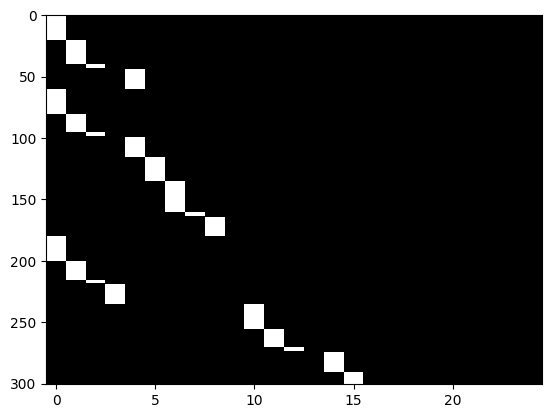

In [4]:
# Reality check for design matrix
plt.imshow(desmtx[:30], aspect='auto', cmap='gray', interpolation='nearest')

### Create data generation function

Here we generate data by adding independent Gaussian noise.  This is not realistic for fMRI, but it should not affect the results of the simulations qualitatively.

(6300, 1)


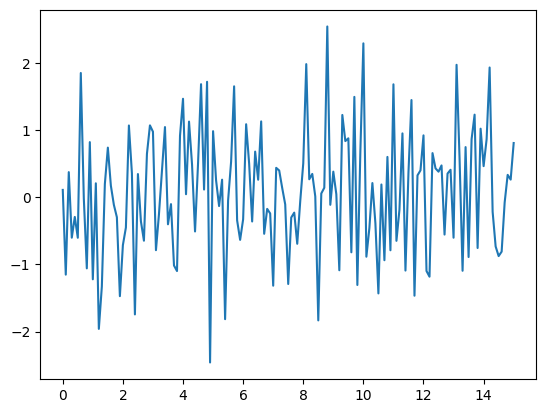

In [5]:
def generate_data(desmtx_conv, beta_dict, noise_sd=1, beta_sub_sd=1):
    """
    Generate data based on the design matrix and beta values

    Parameters
    ----------

    desmtx_conv : pd.DataFrame
        Design matrix with convolved regressors
    beta_dict : dict
        Dictionary of beta values for each regressor of interest
    noise_sd : float
        Standard deviation of the noise
    beta_sub_sd : float
        Standard deviation of the betas across subjects
    """
    # check the beta dict
    betas = np.zeros(desmtx_conv.shape[1])
    for key in beta_dict.keys():
        assert key in desmtx_conv.columns, f'{key} not in desmtx'
    betas = np.array([beta_dict[key] if key in beta_dict.keys() else 0 for key in desmtx_conv.columns ], dtype='float32')
    if beta_sub_sd > 0:
        betas += np.random.normal(0, beta_sub_sd, betas.shape)

    data = np.dot(desmtx_conv.values, betas) + np.random.normal(0, noise_sd, desmtx_conv.shape[0])
    data_df = pd.DataFrame({'data': data})
    data_df.index = desmtx_conv.index
    return data_df

beta_dict = {'CUE_LargeGain': 1, 'CUE_SmallGain': 1} 
data = generate_data(desmtx_conv, beta_dict)
print(data.shape)
plt.plot(data.data[:15])


### Create models of interest

Here we create three models, based on those used in the Demidenko et al., 2024 multiverse analyses.

In [6]:
# create the three models
# all models include feedback for hit/miss in each condition
# then we use the relevant regressors for each model to create the
# anticipation regressor

def convolve_regressors(sf, resolution=.1):
    sf_conv = pd.DataFrame(columns=sf.columns, index=sf.index)
    for col in sf.columns:
        sf_conv[col] = np.convolve(sf[col].values, 
                                spm_hrf(resolution))[:sf_conv.shape[0]]
    return sf_conv



def dropcols(df, conds_to_drop):
    for cond in df.columns:
        if any([drop in cond for drop in conds_to_drop]):
            df.drop(cond, axis=1, inplace=True)
    return df


# set all designs to have the same order of columns
def reorder_cols(df):
    conds = ['NoMoneyStake', 'LargeGain', 'SmallGain', 'LargeLoss', 'SmallLoss']
    regs = ['ANT', 'FEEDBACK_HIT', 'FEEDBACK_MISS']
    newcols = []
    for cond in conds:
        for reg in regs:
            newcols.append(f'{reg}_{cond}')
    assert set(df.columns) == set(newcols), f'Columns do not match: {set(df.columns)} != {set(newcols)}'
    return df[newcols]

def create_models(desmtx):

    # 1. MID: Cue Onset, Cue Duration only 
    CueOnly = desmtx.copy()
    CueOnly = dropcols(CueOnly, ['FIXATION', 'PROBE'])
    # rename CUE to ANT
    for col in CueOnly.columns:
        if 'CUE' in col:
            CueOnly.rename(columns={col: col.replace('CUE', 'ANT')}, inplace=True)
    CueOnly = reorder_cols(CueOnly)

    # 2. MID: Cue Onset, Cue + Fixation Duration
    CueFix = desmtx.copy()
    for col in CueFix.columns:
        if 'FIX' in col:
            new_colname = col.replace('FIXATION', 'ANT')
            # combine cue and fixation regressors and clip to deal with overlap
            CueFix[new_colname] = np.clip(CueFix[col.replace('FIXATION', 'CUE')].values + CueFix[col].values, 0, 1)
    CueFix = dropcols(CueFix, ['CUE', 'FIXATION', 'PROBE'])
    CueFix = reorder_cols(CueFix)

    # 3. MID: Fixation onset, Fixation Duration
    FixOnly = desmtx.copy()
    FixOnly = dropcols(FixOnly, ['CUE', 'PROBE'])
    # rename FIXATION to ANT
    for col in FixOnly.columns:
        if 'FIXATION' in col:
            FixOnly.rename(columns={col: col.replace('FIXATION', 'ANT')}, inplace=True)
    FixOnly = reorder_cols(FixOnly)

    return {'CueOnly': CueOnly, 'CueFix': CueFix, 'FixOnly': FixOnly}

models = create_models(desmtx)
models_conv = {key: convolve_regressors(value) for key, value in models.items()}

# make sure all models have the same regressors - ignoring order
assert models['CueOnly'].columns.equals(models['CueFix'].columns)
assert models['CueOnly'].columns.equals(models['FixOnly'].columns)

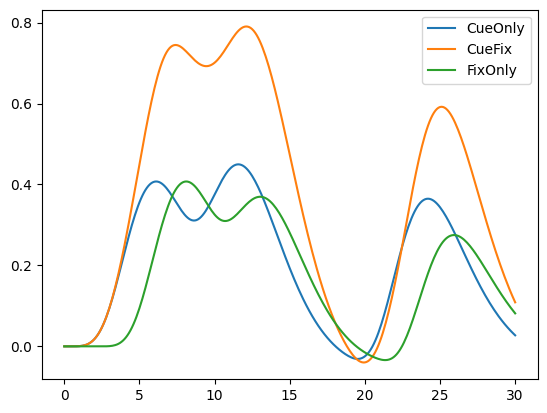

In [7]:
# plot regressors for reality check
plt.plot(models_conv['CueOnly']['ANT_NoMoneyStake'][:30])
plt.plot(models_conv['CueFix']['ANT_NoMoneyStake'][:30])
plt.plot(models_conv['FixOnly']['ANT_NoMoneyStake'][:30])
plt.legend(['CueOnly', 'CueFix', 'FixOnly'])

### Estimate the model and run contrasts

Here we run the model using OLS (which is appropriate given the noise structure) and estimate the four most common contrasts for the MID task based on Demidenko et al. (2020) review of the literature.

In [8]:

def run_model(model, data, add_constant=True):
    if add_constant:
        model =  sm.add_constant(model)
    return sm.OLS(data, model).fit()


model = run_model(models_conv['CueOnly'], data)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   data   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     119.2
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:39:36   Log-Likelihood:                -8991.7
No. Observations:                6300   AIC:                         1.802e+04
Df Residuals:                    6284   BIC:                         1.812e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [9]:
def get_contrasts(model):
    # Common contrasts from Demidenko 2020:
    # Based on my prior literature check, the distributions of contrasts: Across 37 studies 61 modeled contrasts:
    # Anticipation (n = 43, 70%):
    # 49% - All Win > Neutral
    # 16% Big Win > Neutral
    # 14% Big Win > Small Win
    # 12% Loss > Neutral
    # 9% others (Big Loss > Neutral; Small Win > Neutral; Win (or Loss) > Implicit Baseline)
    # Outcome (n = 8, 13%):
    # 34% Reward Hit > Neutral Hit
    # 25% Big Win Hit > Big Win Miss
    # 38% others (Big Win Hit > Neutral Hit; Big Win Miss > Neutral Miss; Loss Miss > Neutral Miss)

    contrast_dict = {}
    # all win vs neutral
    c1 = np.zeros(len(model.params))
    c1[model.params.index == 'ANT_LargeGain'] = 0.5
    c1[model.params.index == 'ANT_SmallGain'] = 0.5
    c1[model.params.index == 'ANT_NoMoneyStake'] = -1
    contrast_dict['Ant:W-Neut'] = c1

    # big win vs neutral
    c2 = np.zeros(len(model.params))
    c2[model.params.index == 'ANT_LargeGain'] = 1
    c2[model.params.index == 'ANT_NoMoneyStake'] = -1
    contrast_dict['Ant:LW-Neut'] = c2

    # Reward Hit > Neutral Hit
    c3 = np.zeros(len(model.params))
    c3[model.params.index == 'FEEDBACK_HIT_LargeGain'] = 0.5
    c3[model.params.index == 'FEEDBACK_HIT_SmallGain'] = 0.5
    c3[model.params.index == 'FEEDBACK_HIT_NoMoneyStake'] = -1
    contrast_dict['FB:WHit-NeutHit'] = c3
    
    # Big Win Hit > Big Win Miss
    c4 = np.zeros(len(model.params))
    c4[model.params.index == 'FEEDBACK_HIT_LargeGain'] = 1
    c4[model.params.index == 'FEEDBACK_MISS_LargeGain'] = -1
    contrast_dict['FB:LWHit-LWMiss'] = c4

    contrasts = [c1, c2, c3, c4]
    result = model.t_test(contrasts).summary_frame()[['coef', 'P>|t|']]
    result['contrast'] = contrast_dict.keys()
    return result, contrast_dict

t_test_results, contrast_dict = get_contrasts(model)
print(t_test_results)



        coef         P>|t|         contrast
c0  1.078512  1.654364e-18       Ant:W-Neut
c1 -0.085805  5.467186e-01      Ant:LW-Neut
c2 -3.573932  2.406713e-60  FB:WHit-NeutHit
c3 -0.161412  4.517369e-01  FB:LWHit-LWMiss


## Run simulations for all models in several true signal scenarios

In each of the following, we generate a true signal for specific components of the design, and assess the results for the most common contrasts.

Note: The SNR was adjusted manually for each simulation based on pilot results in order to give detection power of roughly 90% for the best contrast/model, to maximize the dynamic range for the full set of contrasts/models.




In [10]:
## important modeling parameters

nsims = 1000  # number of simulations per subject
overwrite = False  # overwrite existing data

# load existing data if they are there
if os.path.exists('all_sims.pkl') and not overwrite:
    with open('all_sims.pkl', 'rb') as f:
        all_sims = pickle.load(f)
    print(f'Loaded simulations from file.')
    print(all_sims.keys())
else:
    all_sims = {}

### Null model

In [11]:
def process_subject(sub, beta_dict, noise_sd, resolution=.1, verbose=False):
    all_results = None
    try:
        events = get_subdata(sub)
    except:
        if verbose:
            print(f'Error loading sub {sub}')
        return None
    desmtx, desmtx_conv  = create_design_matrix(events, resolution=resolution)
    models = create_models(desmtx)
    models_conv = {key: convolve_regressors(value) for key, value in models.items()}
    data = generate_data(desmtx_conv, beta_dict, noise_sd=noise_sd)
    for key, model_desmtx in models_conv.items():
        model_results = run_model(model_desmtx, data)
        t_test_results, contrast_dict = get_contrasts(model_results)
        t_test_results['sub'] = sub
        t_test_results['model'] = key
        if all_results is None:
            all_results = t_test_results
        else:
            all_results = pd.concat([all_results, t_test_results])
    return all_results


def summarize_results(results, threshold=.05):
    summary = []
    for contrast in results.contrast.unique():
        for model in results.model.unique():
            # do one-sample t-test across subjects
            coefs = results.query('contrast == @contrast').query('model == @model')['coef']
            assert len(coefs) == 107, f'Bad number of subjects: {len(coefs)}'
            assert coefs.isnull().sum() == 0, f'Nans in coefs'
            ttest = ttest_1samp(coefs, 0, alternative='greater')
            contrast_df = [contrast, model, ttest.statistic, ttest.pvalue,
                ttest.pvalue < threshold, coefs.mean()]
            summary.append(contrast_df)
    summary_df = pd.DataFrame(summary, columns=['contrast', 'model', 'tstat', 'pval', 'sigp', 'mean'])
    return summary_df


def resultlist_to_df(results, verbose=False):
    all_results = None
    for i, result in enumerate(results):
        if result is None:
            if verbose:
                print(f'Error in simulation {i + 1} - result is empty')
            continue
        if all_results is None:
            all_results = result
        else:
            all_results = pd.concat([all_results, result])
    all_results.reset_index(drop=True, inplace=True)
    return all_results

def run_simulation(beta_dict, nsims=100, threshold=0.05, noise_sd=1.0, resolution=.1, n_jobs=None):
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count() - 2  # save two cores for the OS
    all_results = None
    if len(beta_dict) == 0:
        true_signal = 'null'
    else:
        true_signal = beta_dict
    print(f'Running simulation for {true_signal}')
    for sim in tqdm(range(nsims)):  # wrap range with tqdm for progress bar
        sim_results = None
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_subject)(i, beta_dict, noise_sd) for i in range(1, 109)
            )
        sim_results = resultlist_to_df(results)
        summary = summarize_results(sim_results, threshold)
        summary['sim'] = sim
        if all_results is None:
            all_results = summary
        else:
            all_results = pd.concat([all_results, summary])
    return all_results



In [12]:
if 'null' not in all_sims.keys():
    beta_dict = {} 
    noise_sd = 1.0
    all_sims['null'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for null


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [18:14<00:00,  1.09s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


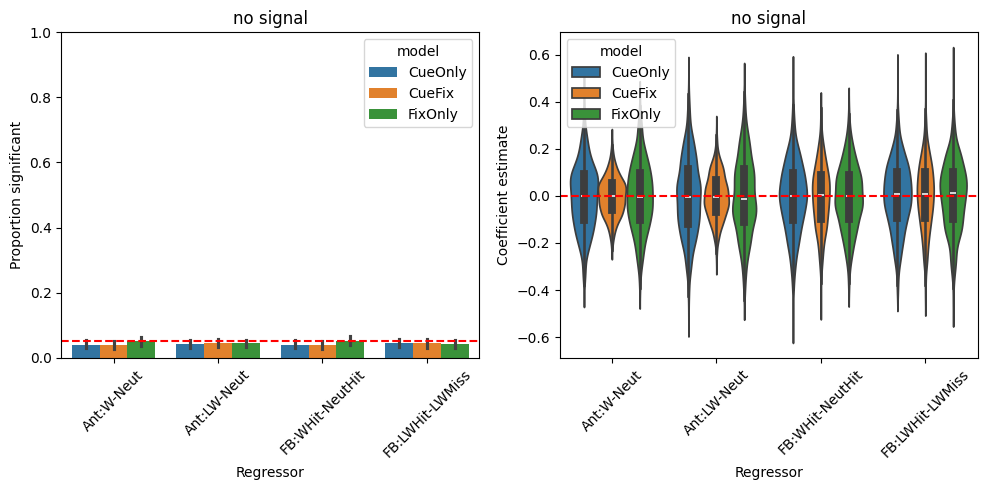

In [13]:
def plot_results(results_df, noise_sd, label):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    sns.barplot(data=results_df, x='contrast', y='sigp', hue='model', ax=axs[0])
    axs[0].set_title(label)
    axs[0].set_ylim(0,1)
    axs[0].axhline(0.05, color='red', linestyle='--')
    axs[0].set_xlabel('Regressor')
    axs[0].set_ylabel('Proportion significant')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

    sns.violinplot(data=results_df, x='contrast', y='mean', hue='model', ax=axs[1])
    axs[1].axhline(0.0, color='red', linestyle='--')
    axs[1].set_xlabel('Regressor')
    axs[1].set_ylabel('Coefficient estimate')
    axs[1].set_title(label)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

plot_results(all_sims['null'], 1, 'no signal')

### True effect for CUE_Largegain and CUE_Smallgain

In [14]:
beta_dict = {'CUE_LargeGain': 0.5, 'CUE_SmallGain': 0.5} 
noise_sd = 1
if 'CUE:W-Neut' not in all_sims.keys():
    all_sims['CUE:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'CUE_LargeGain': 0.5, 'CUE_SmallGain': 0.5}


100%|██████████| 1000/1000 [18:01<00:00,  1.08s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


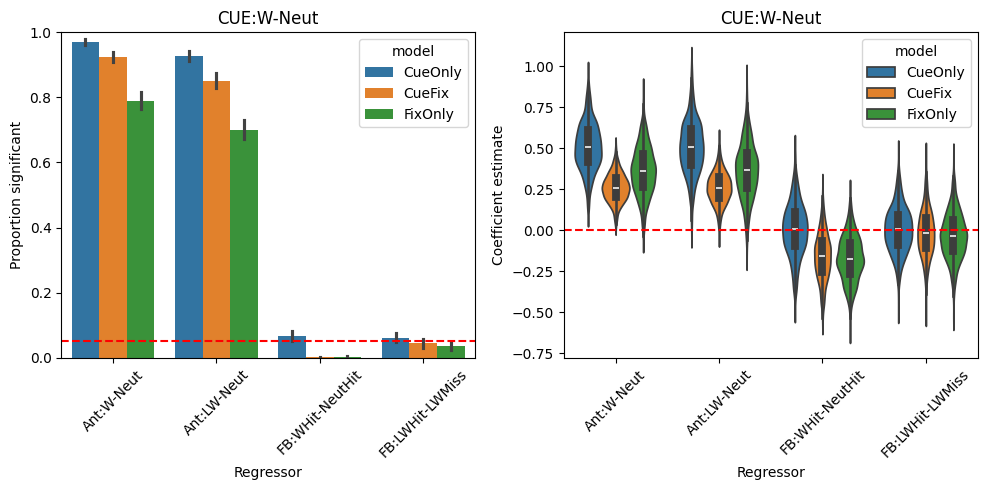

In [15]:
plot_results(all_sims['CUE:W-Neut'], noise_sd, 'CUE:W-Neut')

### True effect for Fixation_Smallgain and Fixation_Largegain

In [16]:
beta_dict = {'FIXATION_LargeGain': 0.5, 'FIXATION_SmallGain': 0.5} 
noise_sd = 1
if 'FIX:W-Neut' not in all_sims.keys():
    all_sims['FIX:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'FIXATION_LargeGain': 0.5, 'FIXATION_SmallGain': 0.5}


100%|██████████| 1000/1000 [18:10<00:00,  1.09s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


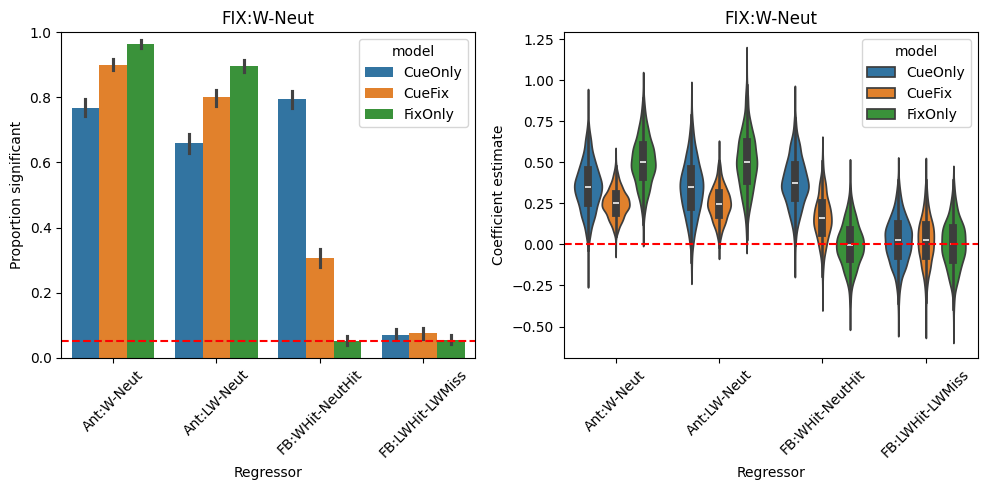

In [17]:
plot_results(all_sims['FIX:W-Neut'], noise_sd, 'FIX:W-Neut')

### True effect for both cue and fixation (i.e. "anticipation") for large/small gain

In [18]:
beta_dict = {'CUE_LargeGain': 0.25, 'CUE_SmallGain': 0.25, 'FIXATION_LargeGain': 0.25, 'FIXATION_SmallGain': 0.25} 
noise_sd = 1
if 'CUEFIX:W-Neut' not in all_sims.keys():
    all_sims['CUEFIX:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'CUE_LargeGain': 0.25, 'CUE_SmallGain': 0.25, 'FIXATION_LargeGain': 0.25, 'FIXATION_SmallGain': 0.25}


100%|██████████| 1000/1000 [18:14<00:00,  1.09s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


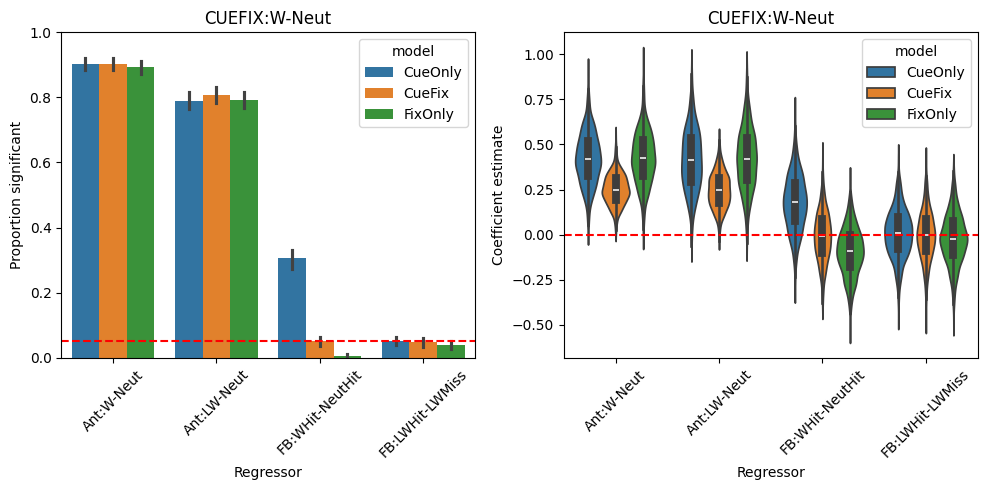

In [19]:
plot_results(all_sims['CUEFIX:W-Neut'], noise_sd, 'CUEFIX:W-Neut')

### True activation for Probe in both gain conditions

In [20]:
beta_dict = {'PROBE_LargeGain': 1, 'PROBE_SmallGain': 1} 
noise_sd = 1
if 'PROBE:W-Neut' not in all_sims.keys():
    all_sims['PROBE:W-Neut'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'PROBE_LargeGain': 1, 'PROBE_SmallGain': 1}


100%|██████████| 1000/1000 [18:23<00:00,  1.10s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


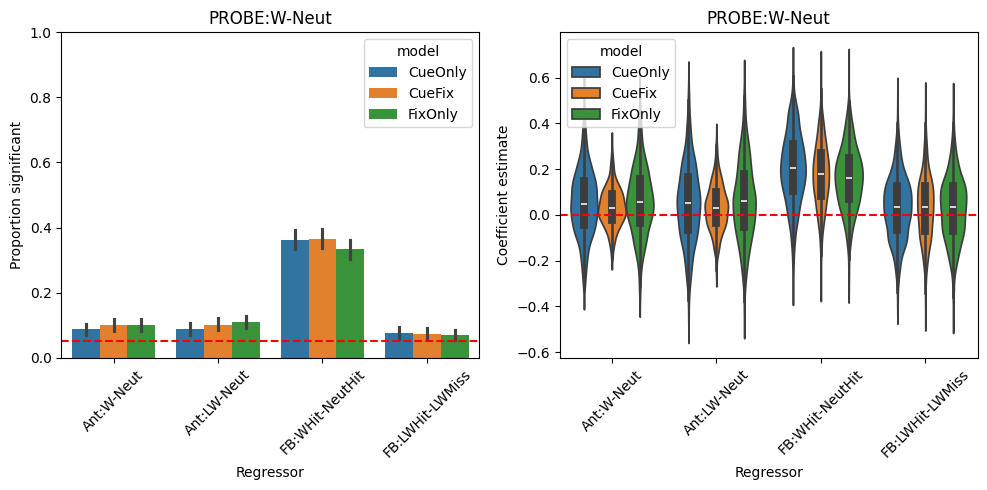

In [21]:
plot_results(all_sims['PROBE:W-Neut'], noise_sd, 'PROBE:W-Neut')

### True activation for win-hit vs neutral hit

In [22]:
beta_dict = {'FEEDBACK_HIT_LargeGain': 0.5, 'FEEDBACK_HIT_SmallGain': 0.5} 
noise_sd = 1
if 'FB:WHit-NeutHit' not in all_sims.keys():
    all_sims['FB:WHit-NeutHit'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'FEEDBACK_HIT_LargeGain': 0.5, 'FEEDBACK_HIT_SmallGain': 0.5}


100%|██████████| 1000/1000 [18:23<00:00,  1.10s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


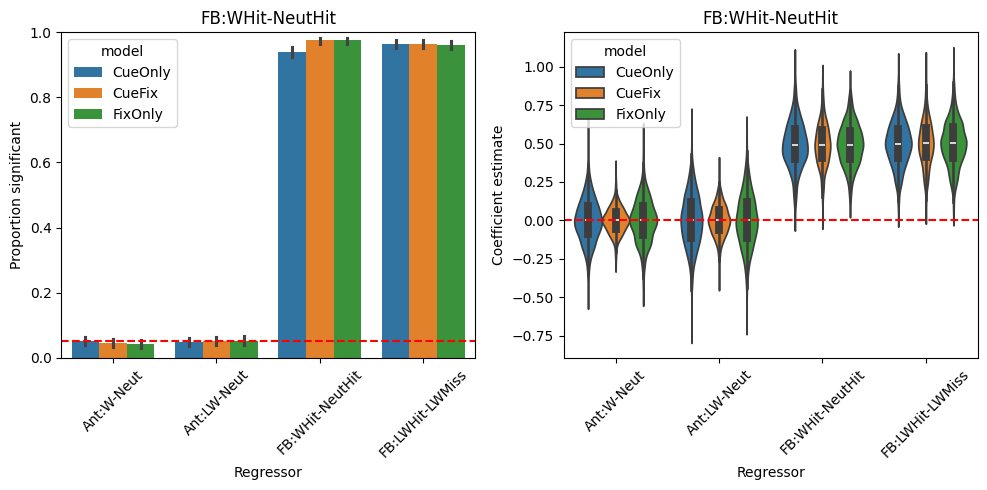

In [23]:
plot_results(all_sims['FB:WHit-NeutHit'], noise_sd, 'FB:WHit-NeutHit')

### True activation for Feedback LWHit vs LWMiss

In [24]:
beta_dict = {'FEEDBACK_HIT_LargeGain': 0.25, 'FEEDBACK_MISS_LargeGain': -0.25} 
noise_sd = 1
if 'FB:LWHit-LWMiss' not in all_sims.keys():
    all_sims['FB:LWHit-LWmiss'] = run_simulation(beta_dict, nsims=nsims, noise_sd=noise_sd, resolution=.1)

Running simulation for {'FEEDBACK_HIT_LargeGain': 0.25, 'FEEDBACK_MISS_LargeGain': -0.25}


100%|██████████| 1000/1000 [18:42<00:00,  1.12s/it]


/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
/var/folders/r2/f85nyfr1785fj4257wkdj7480000gn/T/ipykernel_89496/3766789459.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


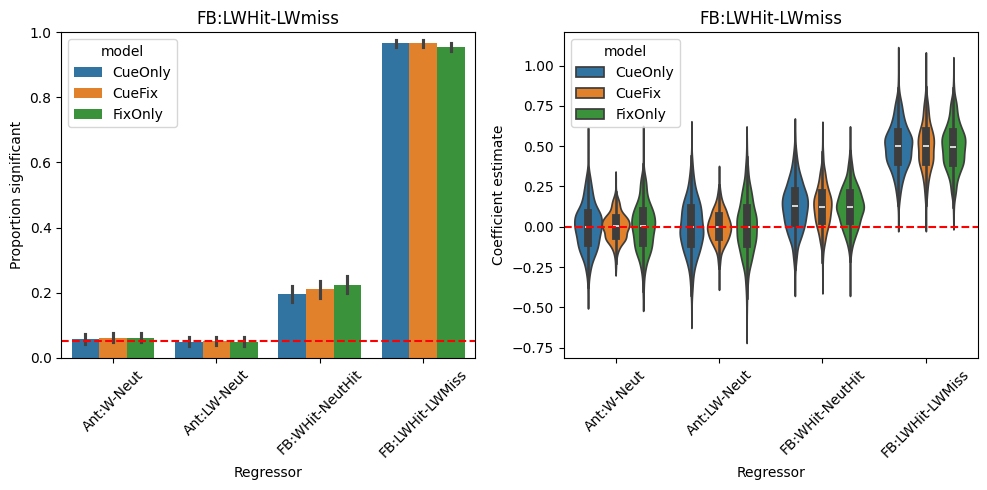

In [25]:
plot_results(all_sims['FB:LWHit-LWmiss'], noise_sd, 'FB:LWHit-LWmiss')

### Store the results

In [26]:
with open('all_sims.pkl', 'wb') as f:
    pickle.dump(all_sims, f)